In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, TimeSeriesTransformerModel
from transformers.models.time_series_transformer.modeling_time_series_transformer import TimeSeriesTransformerEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats
import seaborn as sns
from sklearn.metrics import confusion_matrix

from core.dataset import MachoDataset
from core.trainer import PredictionTrainer, ClassificationTrainer
from core.model import ClassificationModel

/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
class CustomModel(nn.Module):
    def __init__(self, encoder, device, num_classes):
        super(CustomModel, self).__init__()
        
        self.device = device
        self.encoder = encoder
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.encoder.config.d_model, num_classes)

    def forward(self, values, mask):
        encoder_outputs = self.encoder(inputs_embeds=values.unsqueeze(-1), attention_mask=mask)
        emb = encoder_outputs.last_hidden_state[:, 0, :]     # we will use the 1 element only, analog to CLS?
        res = self.classifier(emb)

        return res

In [5]:
def train_epoch():
    model.train()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0
    
    for batch in train_dataloader:
        _, times, _, values, _, mask, aux, labels = batch
        labels = labels.to(device)
        values, mask = values.to(device), mask.to(device)
    
        optimizer.zero_grad()
    
        logits = model(values, mask)
        loss = criterion(logits, labels)
        total_loss.append(loss.item())
    
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
    
        total_correct_predictions += correct_predictions
        total_predictions += labels.size(0)
    
        loss.backward()
        optimizer.step()

    print(f'Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}', end=' ')

In [6]:
def val_epoch():
    model.eval()

    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            _, times, _, values, _, mask, aux, labels = batch
            labels = labels.to(device)
            values, mask = values.to(device), mask.to(device)

            logits = model(values, mask)
            loss = criterion(logits, labels)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()

            total_correct_predictions += correct_predictions
            total_predictions += labels.size(0)

    print(f'Total Loss: {round(sum(total_loss) / len(total_loss), 5)} Accuracy: {round(total_correct_predictions / total_predictions, 3)}')

In [22]:
batch = next(iter(val_dataloader))
_, times, _, values, _, mask, aux, labels = batch
labels.dtype

torch.int64

In [7]:
def plot_confusion(all_true_labels, all_predicted_labels):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    # Calculate percentage values for confusion matrix
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot both confusion matrices side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

    # Plot absolute values confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix - Absolute Values')

    # Plot percentage values confusion matrix
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues', ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix - Percentages')

In [8]:
config = {
    'random_seed': random_seed,
    'data_root': '/home/mrizhko/AML/contra_periodic/data/macho/',
    'balanced_data_root': '/home/mrizhko/AML/AstroML/data/macho-balanced/',
    'weights_path': '/home/mrizhko/AML/AstroML/weights/',

    # Time Series Transformer
    'lags': None,  # ?
    'distribution_output': 'normal',
    'num_static_real_features': 0,  # if 0 we don't use real features
    'num_time_features': 1,
    'd_model': 512,
    'decoder_layers': 4,
    'encoder_layers': 2,
    'dropout': 0,
    'encoder_layerdrop': 0,
    'decoder_layerdrop': 0,
    'attention_dropout': 0,
    'activation_dropout': 0,

    # Data
    'window_length': 200,
    'prediction_length': 0,  # 1 5 10 25 50

    # Training
    'batch_size': 256,
    'lr': 1e-3,
    'weight_decay': 0,
    'epochs_pre_training': 1000,
    'epochs_fine_tuning': 100,
    
    # Learning Rate Scheduler
    'factor': 0.3,
    'patience': 10,

    'mode': 'fine-tuning',  # 'pre-training' 'fine-tuning' 'both'
    'save_weights': False,
    'config_from_run': None,  # 'MeriDK/AstroML/qtun67bq'
}

In [9]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cuda:2


In [10]:
train_dataset = MachoDataset(config['data_root'], config['window_length'], mode='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

In [11]:
val_dataset = MachoDataset(config['data_root'], config['window_length'], mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [12]:
len(train_dataset), len(val_dataset)

(48047, 16014)

In [13]:
transformer_config = TimeSeriesTransformerConfig(
    prediction_length=10,
    context_length=200,
    num_time_features=config['num_time_features'],
    num_static_real_features=config['num_static_real_features'],
    encoder_layers=config['encoder_layers'],
    d_model=config['d_model'],
    distribution_output='normal',
    scaling=None,
    dropout=config['dropout'],
    encoder_layerdrop=config['encoder_layerdrop'],
    decoder_layerdrop=config['decoder_layerdrop'],
    attention_dropout=config['attention_dropout'],
    activation_dropout=config['activation_dropout']
)
transformer_config.feature_size = 1

In [14]:
encoder = TimeSeriesTransformerEncoder(transformer_config)

In [15]:
model = CustomModel(encoder, device, 8)

In [16]:
optimizer = AdamW(model.parameters(), lr=config['lr'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=config['factor'], patience=config['patience'], verbose=True)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

In [18]:
for i in range(10):
    print(f'Epoch {i}', end=' ')
    train_epoch()
    val_epoch()

Epoch 0 Total Loss: 1.2353 Accuracy: 0.495 Total Loss: 1.2613 Accuracy: 0.496
Epoch 1 Total Loss: 1.2425 Accuracy: 0.496 Total Loss: 1.2496 Accuracy: 0.506
Epoch 2 Total Loss: 1.22791 Accuracy: 0.502 Total Loss: 1.24998 Accuracy: 0.504
Epoch 3 Total Loss: 1.22942 Accuracy: 0.501 Total Loss: 1.248 Accuracy: 0.505
Epoch 4 Total Loss: 1.22411 Accuracy: 0.503 Total Loss: 1.23575 Accuracy: 0.513
Epoch 5 Total Loss: 1.23573 Accuracy: 0.5 Total Loss: 1.27815 Accuracy: 0.489
Epoch 6 Total Loss: 1.24212 Accuracy: 0.499 Total Loss: 1.25981 Accuracy: 0.499
Epoch 7 Total Loss: 1.23122 Accuracy: 0.503 Total Loss: 1.2647 Accuracy: 0.497
Epoch 8 Total Loss: 1.23068 Accuracy: 0.501 Total Loss: 1.24838 Accuracy: 0.511
Epoch 9 Total Loss: 1.2247 Accuracy: 0.505 Total Loss: 1.2531 Accuracy: 0.505


In [61]:
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for batch in val_dataloader:
        _, times, _, values, _, mask, aux, labels = batch
        values, mask = values.to(device), mask.to(device)
    
        logits = model(values, mask)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        y_pred.append(predicted_labels)
        y_true.append(labels)

y_pred = torch.hstack(y_pred).cpu()
y_true = torch.hstack(y_true)

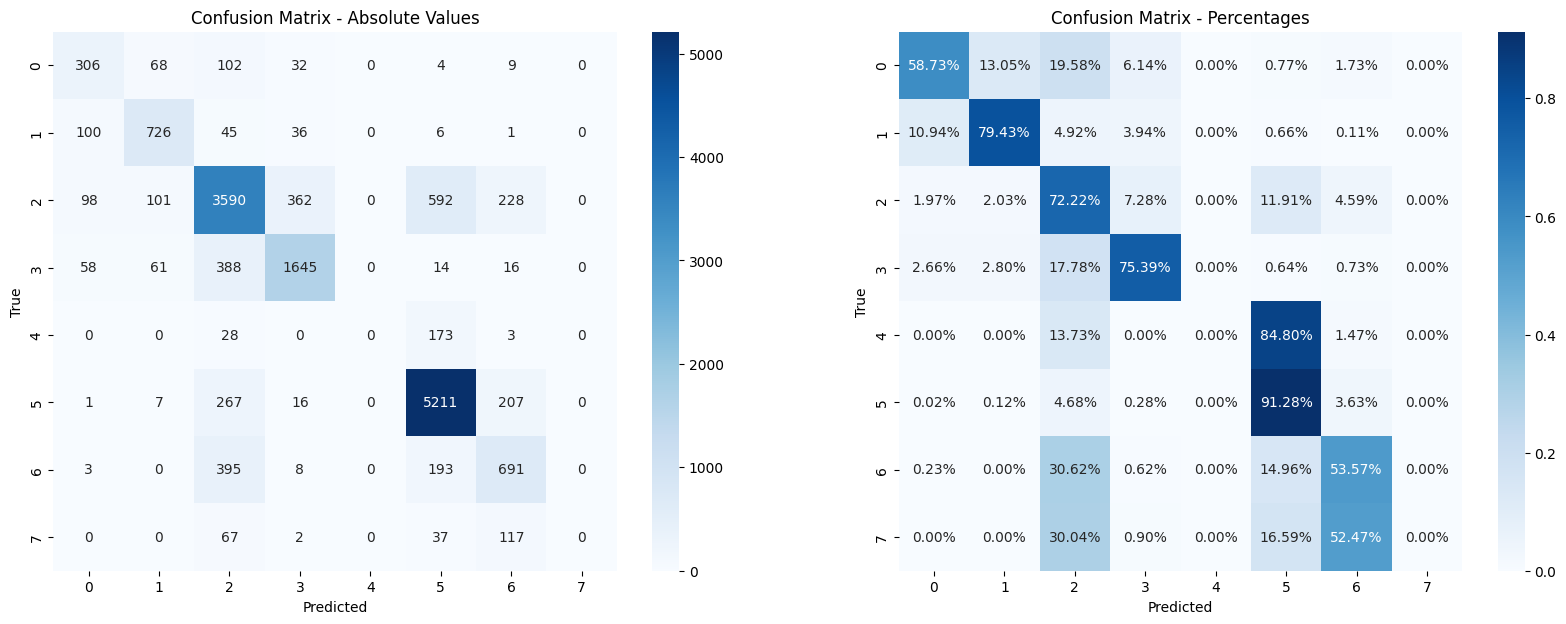

In [62]:
plot_confusion(y_true, y_pred)

In [38]:
_, times, _, values, _, mask, aux, labels = next(iter(train_dataloader))

In [39]:
times.shape, values.shape, mask.shape

(torch.Size([512, 200, 1]), torch.Size([512, 200]), torch.Size([512, 200]))

In [40]:
values.unsqueeze(-1).shape

torch.Size([512, 200, 1])

In [45]:
encoder_outputs = encoder(
    inputs_embeds=values.unsqueeze(-1),
    attention_mask=mask,
)

In [46]:
encoder_outputs.last_hidden_state.shape

torch.Size([512, 200, 256])

In [58]:
model(values, mask).shape

torch.Size([512, 8])

In [18]:
embedder = TimeSeriesTransformerModel(transformer_config)

In [19]:
model = ClassificationModel(pretrained_model=embedder, device=device)


In [20]:
trainer = ClassificationTrainer(model=model, optimizer=optimizer, scheduler=scheduler, 
                                criterion=criterion, device=device)

In [21]:
trainer.train(train_dataloader, train_dataloader, epochs=1000)

Epoch 0: Train Loss 2.1046 	 Val Loss 2.0914 	                     Train Acc 0.1351 	 Val Acc 0.1256
Epoch 1: Train Loss 2.0804 	 Val Loss 2.0744 	                     Train Acc 0.1282 	 Val Acc 0.1246
Epoch 2: Train Loss 2.0714 	 Val Loss 2.0666 	                     Train Acc 0.1385 	 Val Acc 0.1417
Epoch 3: Train Loss 2.0669 	 Val Loss 2.0598 	                     Train Acc 0.1462 	 Val Acc 0.1528
Epoch 4: Train Loss 2.0559 	 Val Loss 2.0473 	                     Train Acc 0.1585 	 Val Acc 0.1825
Epoch 5: Train Loss 2.0374 	 Val Loss 2.0184 	                     Train Acc 0.1909 	 Val Acc 0.196
Epoch 6: Train Loss 2.001 	 Val Loss 1.9688 	                     Train Acc 0.2214 	 Val Acc 0.2504
Epoch 7: Train Loss 1.9501 	 Val Loss 1.915 	                     Train Acc 0.2498 	 Val Acc 0.2734
Epoch 8: Train Loss 1.8902 	 Val Loss 1.8483 	                     Train Acc 0.2671 	 Val Acc 0.3069
Epoch 9: Train Loss 1.8155 	 Val Loss 1.7625 	                     Train Acc 0.319 	 Val Acc 0

In [22]:
val_dataset = MachoDataset(config['balanced_data_root'], config['prediction_length'], mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

(5.6521071791648865, 0.4575242718446602)


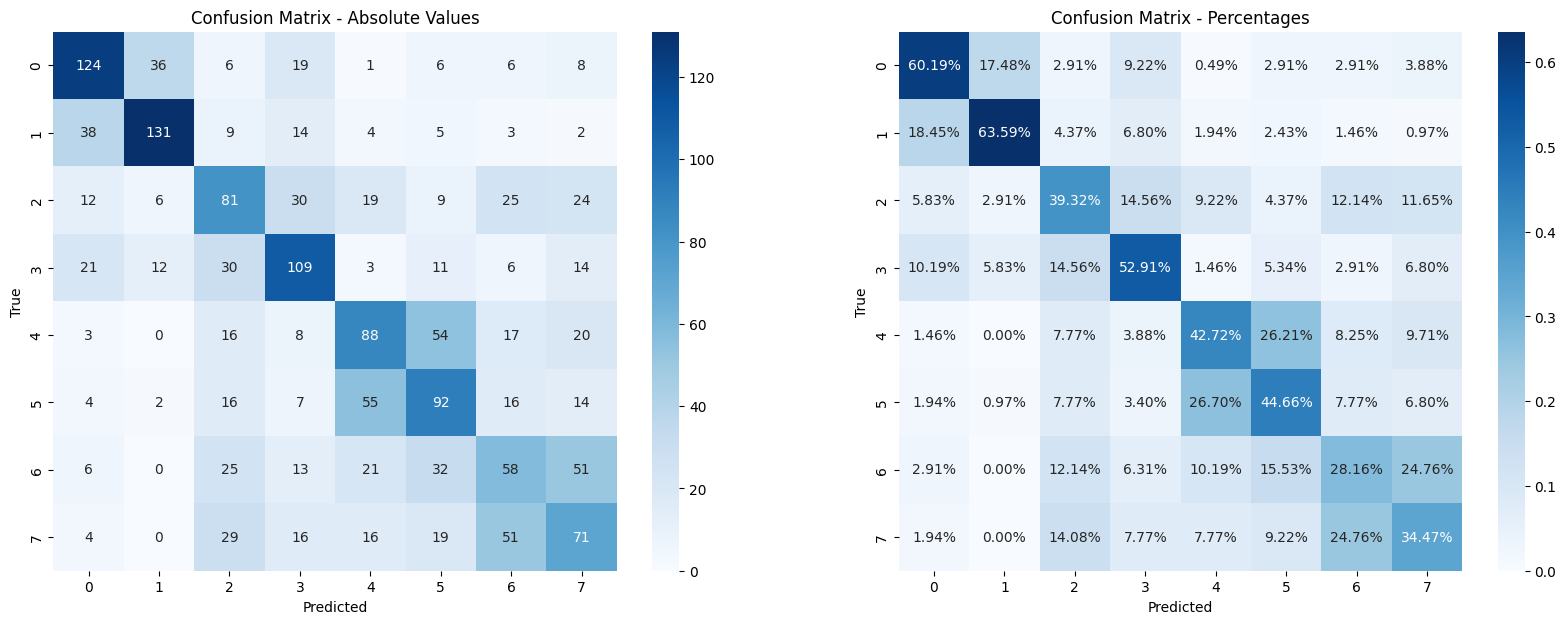

In [23]:
print(trainer.val_epoch(val_dataloader))
trainer.evaluate(val_dataloader)

(0.01166996881365776, 0.9995967741935484)


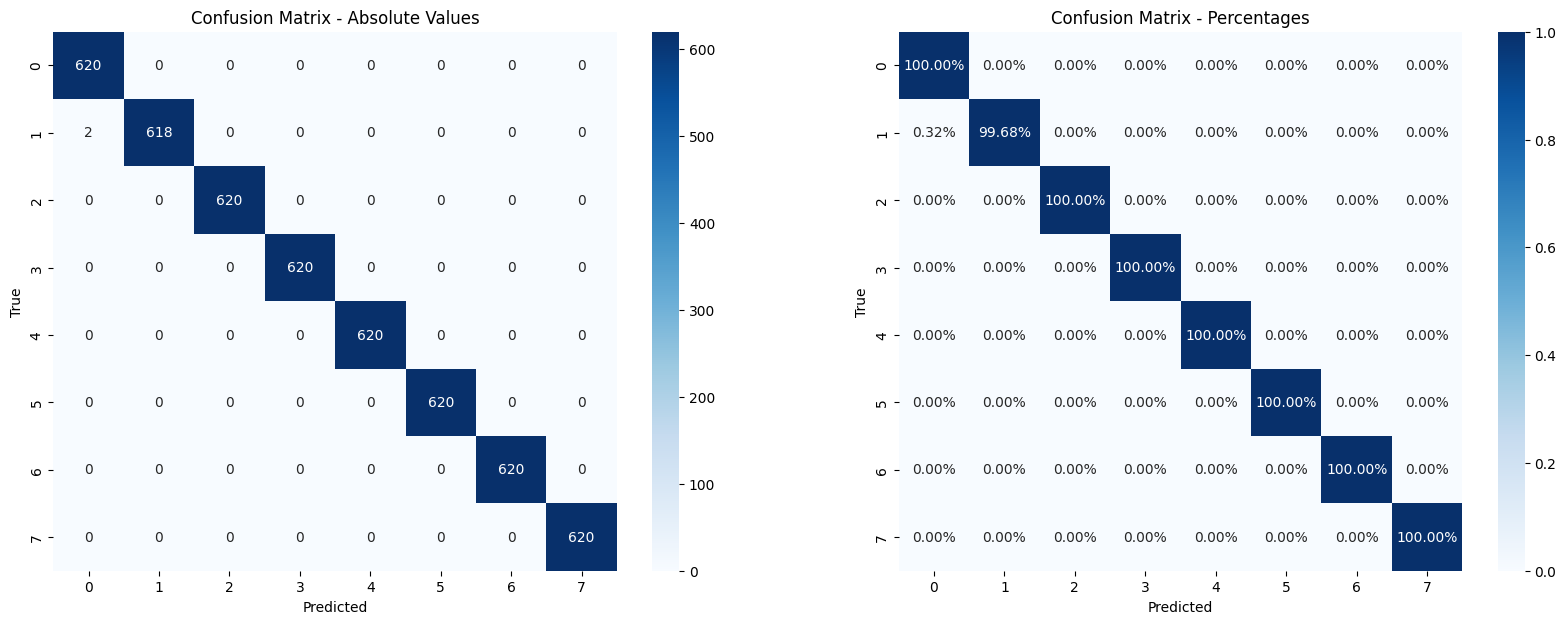

In [24]:
print(trainer.val_epoch(train_dataloader))
trainer.evaluate(train_dataloader)